In [1]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore', DeprecationWarning)


In [2]:
# Standard Libraries
import json
import random
import numpy as np
import pandas as pd

# Visualization Libraries
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import missingno as msno

# Preprocessing Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Transformers Libraries
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
    BertTokenizer,
    BertConfig
)


In [3]:
import json

def load_json_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:  
        file = json.load(f)
    return file


filename = '../Data/intents.json'


intents = load_json_file(filename)


print(intents.keys()) 


dict_keys(['intents'])


In [4]:
def create_df():
    return pd.DataFrame({
        'Pattern': [],
        'Tag': []
    })


df = create_df()


print(df.info())  
print(df.head())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Pattern  0 non-null      float64
 1   Tag      0 non-null      float64
dtypes: float64(2)
memory usage: 132.0 bytes
None
Empty DataFrame
Columns: [Pattern, Tag]
Index: []


In [5]:
def extract_json_info(json_file):
    # Create a list to store data
    data = []

    # Iterate through the intents
    for intent in json_file['intents']:
        # Iterate through the patterns in each intent
        for pattern in intent['patterns']:
            # Append pattern and tag to the list
            data.append([pattern, intent['tag']])
    
    
    return pd.DataFrame(data, columns=['Pattern', 'Tag'])

# Extract information from JSON and create a DataFrame
df = extract_json_info(intents)

df.head()


,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [6]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [7]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


In [8]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 6.5+ KB
None


In [9]:
def num_classes(df, target_col, ds_name="df"):
    """
    Prints the number of unique classes in a specified column of a DataFrame.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        target_col (str): The column to check for unique classes.
        ds_name (str): Optional name of the dataset for display purposes.
    
    Returns:
        int: The number of unique classes.
    """
    if target_col not in df.columns:
        print(f"Error: Column '{target_col}' not found in {ds_name} dataset.")
        return None

    unique_classes = len(df[target_col].unique())
    print(f"The {ds_name} dataset has {unique_classes} classes")
    return unique_classes


In [10]:
num_classes_count = num_classes(df, 'Tag', "Chatbot")
print("Number of classes:", num_classes_count)

The Chatbot dataset has 38 classes
Number of classes: 38


In [11]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each column of the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")


Null Values in each column of the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


In [12]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order=None, rotation=False, palette='winter'):
    
    ncount = len(df)
    plt.figure(figsize=(width, height))
    ax = sns.countplot(x=x, data=df, palette=palette, order=order)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation='vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    # Annotate bars with percentages
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate(f'{100.*y/ncount:.1f}%', (x.mean(), y), 
                    ha='center', va='bottom')

    plt.show()


C:\Users\erfan\AppData\Local\Temp\ipykernel_3632\2911759152.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=x, data=df, palette=palette, order=order)


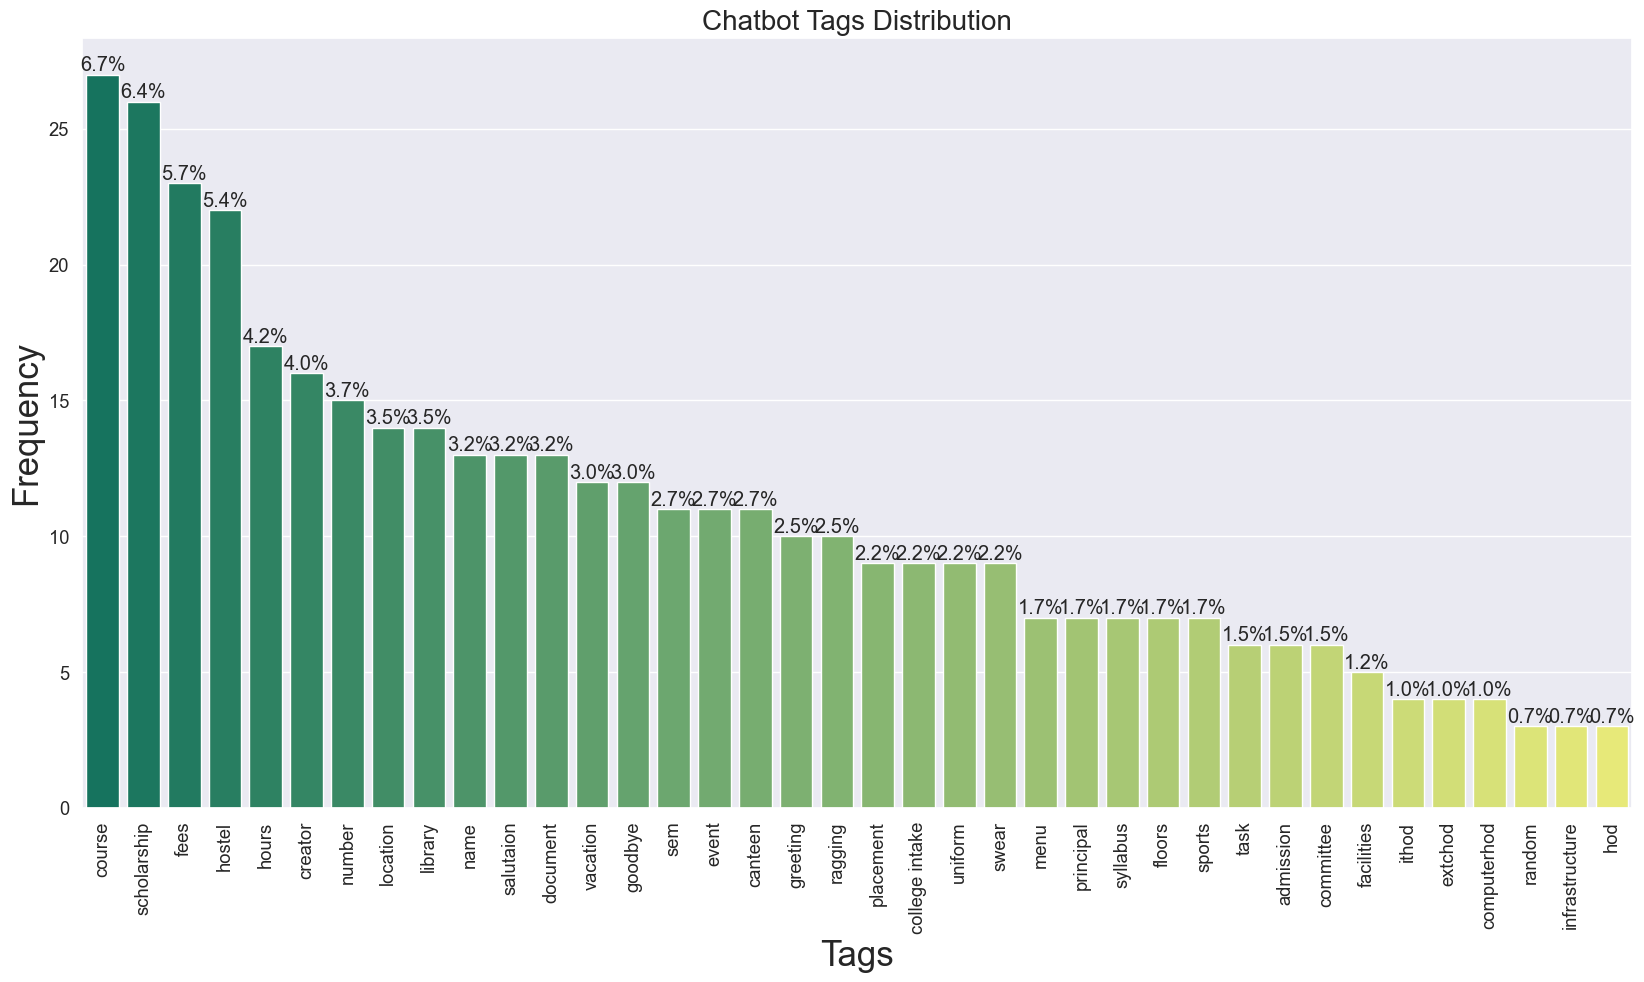

In [13]:
sns.set(font_scale=1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags Distribution", "Tags", "Frequency", 20, 10, order=order, rotation=True, palette="summer")

In [14]:
print(word_tokenize("This is a final test for the punkt tokenizer!"))


['This', 'is', 'a', 'final', 'test', 'for', 'the', 'punkt', 'tokenizer', '!']


In [15]:
stemmer = PorterStemmer()
ignore_words = ['?', '!', ',', '.']

def preprocess_pattern(pattern, ignore_words=ignore_words):
    """
    Preprocesses a text pattern by tokenizing, stemming, and removing unwanted characters.
    
    Args:
        pattern (str): The text pattern to preprocess.
        ignore_words (list): List of words or characters to ignore during processing.
    
    Returns:
        str: The processed text pattern.
    """
    words = word_tokenize(pattern.lower())  # Convert to lowercase and tokenize
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  # Join the processed words into a string

# Apply the preprocessing function to the Pattern column
df['Pattern'] = df['Pattern'].apply(preprocess_pattern)


In [16]:
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


In [17]:
print(df['Pattern'].isnull().sum())

0


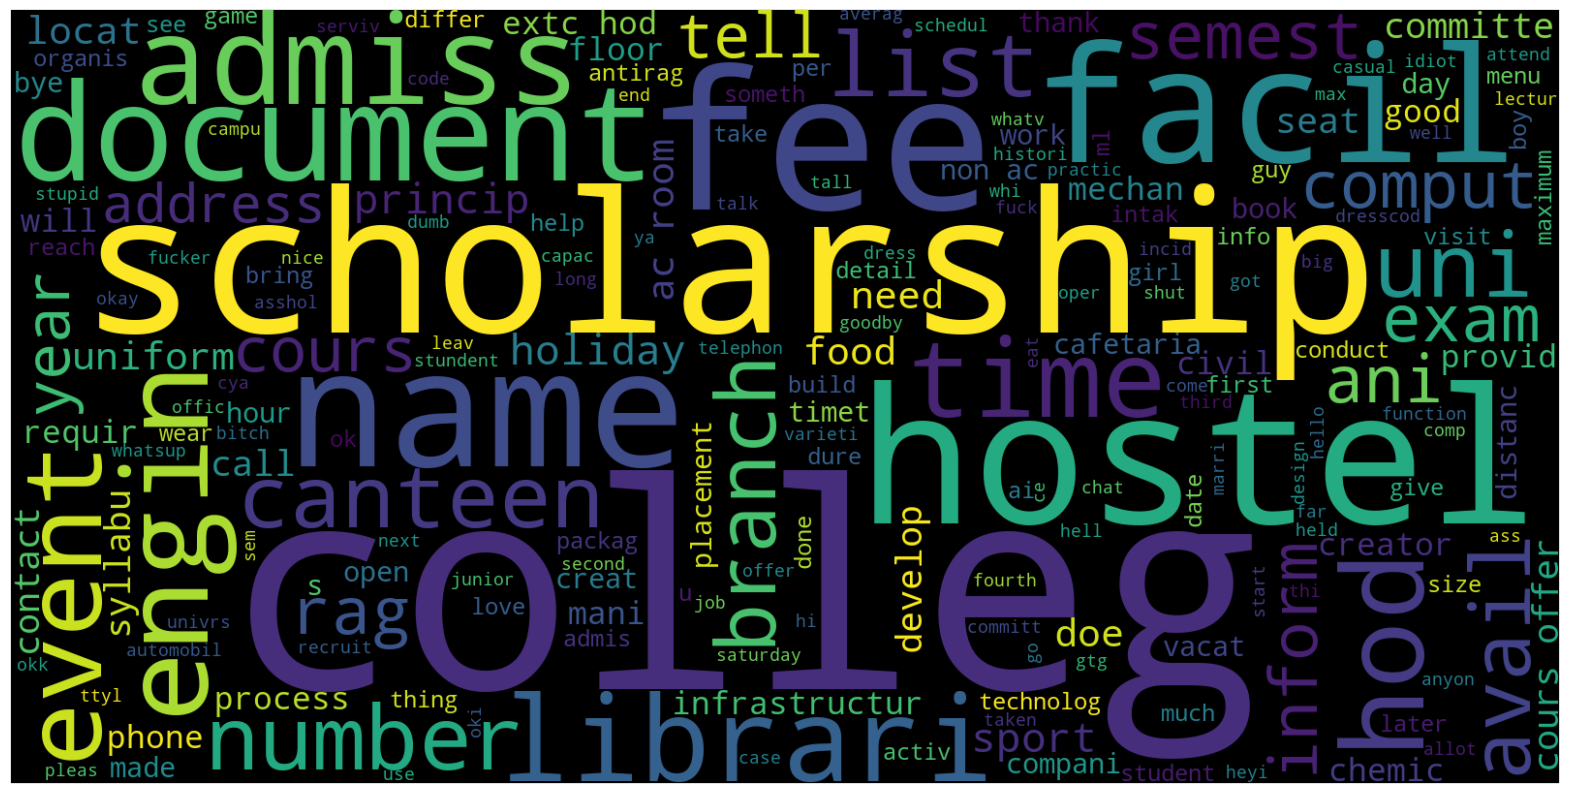

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(20, 20))

# Create WordCloud with specific settings
wc = WordCloud(
    max_words=2000,      
    width=1600,          
    height=800,          
    stopwords=STOPWORDS  
).generate(' '.join(df['Pattern']))  # Combine all preprocessed texts into one string

# Display the WordCloud image
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])  # Hide the x-axis ticks
plt.yticks([])  # Hide the y-axis ticks
plt.show()  


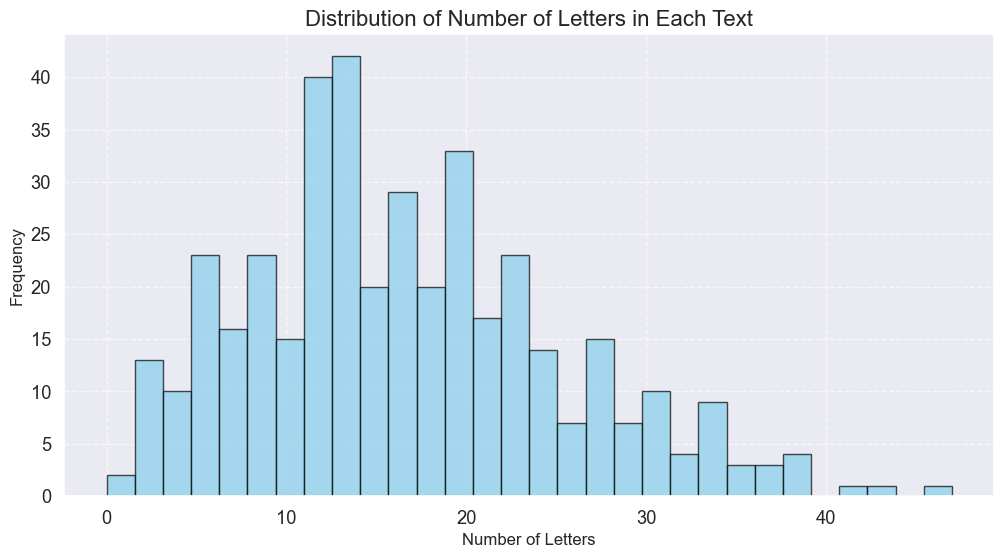

In [19]:
import matplotlib.pyplot as plt

# Calculate the length of each text
letters_len = df['Pattern'].str.len()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(letters_len, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Letters in Each Text", fontsize=16)
plt.xlabel("Number of Letters", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

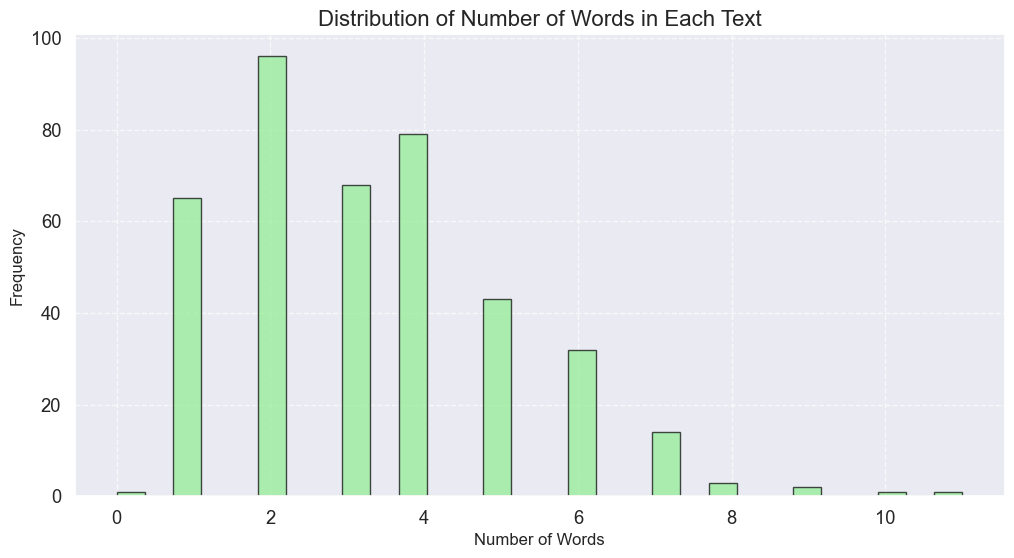

In [20]:
words_len = df['Pattern'].str.split().map(lambda x: len(x))

plt.figure(figsize=(12, 6))
plt.hist(words_len, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Words in Each Text", fontsize=16)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


h:\Users\erfan\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
h:\Users\erfan\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


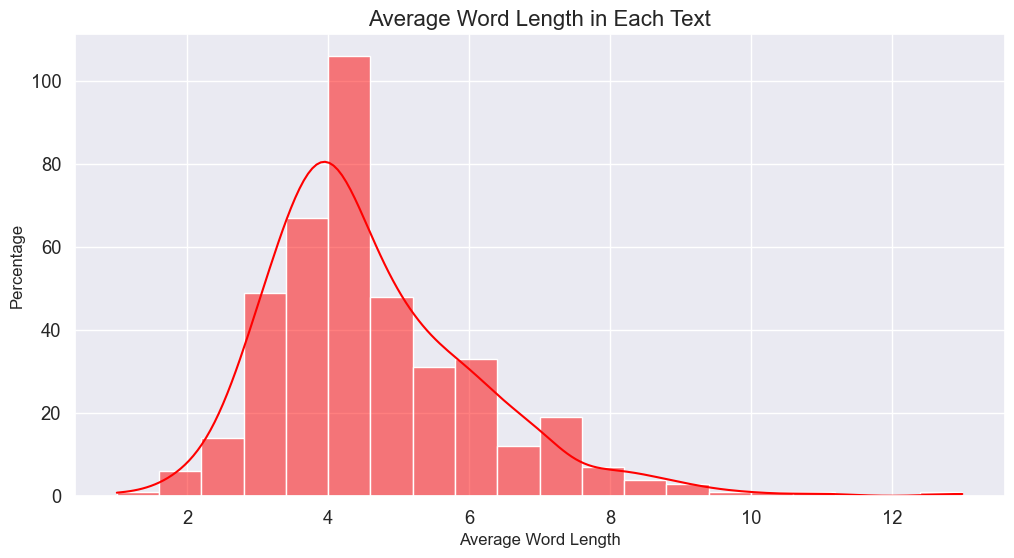

In [21]:
# Calculate average word length in each text
word = df['Pattern'].str.split().apply(lambda x: [len(i) for i in x])
word = word.map(lambda x: np.mean(x))

# Plot the distribution of average word length
plt.figure(figsize=(12, 6))
sns.histplot(word, kde=True, color='red', bins=20)  
plt.title("Average Word Length in Each Text", fontsize=16)
plt.xlabel("Average Word Length", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.show()


In [22]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())  # Removing extra spaces or unwanted characters
    return words

# Creating the corpus
corpus = get_corpus(df['Pattern'])


print(corpus[:5])


['hi', 'how', 'are', 'you', 'is']


In [23]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1345 words


In [24]:
from collections import Counter

# Counting the frequency of each word in the corpus
counter = Counter(corpus)

# Getting the 10 most common words and their counts
most_common = counter.most_common(10)

# Converting the result to a dictionary for easier access
most_common = dict(most_common)

print(most_common)


{'is': 75, 'colleg': 71, 'what': 59, 'the': 46, 'you': 35, 'of': 33, 'in': 29, 'for': 26, 'scholarship': 26, 'are': 25}


C:\Users\erfan\AppData\Local\Temp\ipykernel_3632\2569132861.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()), palette='Blues_d')


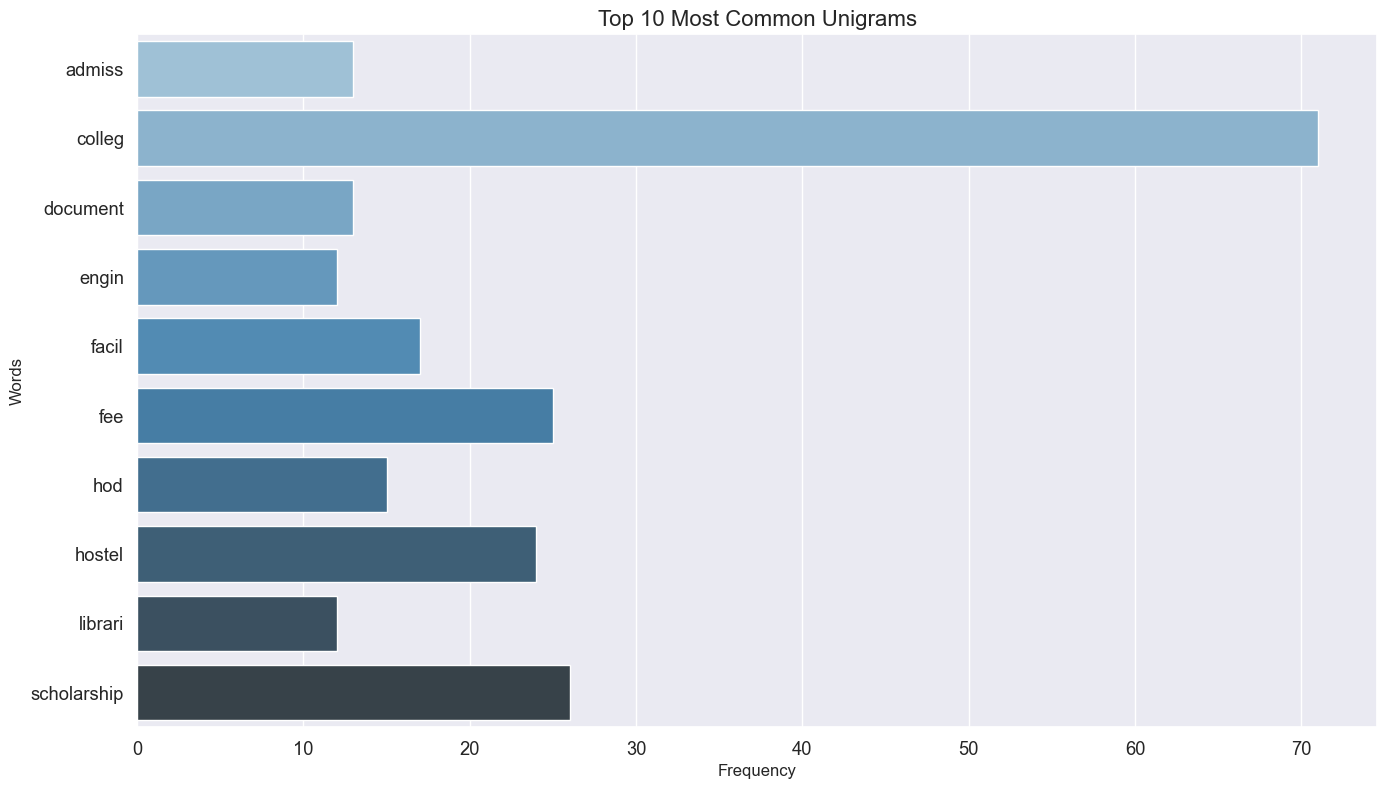

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Extract top 10 unigrams using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(df['Pattern'])

# Get the words and their frequencies
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))


plt.figure(figsize=(16, 9))
sns.barplot(x=list(word_freq.values()), y=list(word_freq.keys()), palette='Blues_d')
plt.title("Top 10 Most Common Unigrams", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)
plt.show()


In [26]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [27]:
# Extract unique labels and clean up extra spaces
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]

print(labels)


['greeting', 'goodbye', 'creator', 'name', 'hours', 'number', 'course', 'fees', 'location', 'hostel', 'event', 'document', 'floors', 'syllabus', 'library', 'infrastructure', 'canteen', 'menu', 'placement', 'ithod', 'computerhod', 'extchod', 'principal', 'sem', 'admission', 'scholarship', 'facilities', 'college intake', 'uniform', 'committee', 'random', 'swear', 'vacation', 'sports', 'salutaion', 'task', 'ragging', 'hod']


In [28]:
# Calculate the number of unique labels
num_labels = len(labels)

# Create a dictionary for mapping ID to label
id2label = {id: label for id, label in enumerate(labels)}

# Create a dictionary for mapping label to ID
label2id = {label: id for id, label in enumerate(labels)}

print("ID to Label:", id2label)
print("Label to ID:", label2id)


ID to Label: {0: 'greeting', 1: 'goodbye', 2: 'creator', 3: 'name', 4: 'hours', 5: 'number', 6: 'course', 7: 'fees', 8: 'location', 9: 'hostel', 10: 'event', 11: 'document', 12: 'floors', 13: 'syllabus', 14: 'library', 15: 'infrastructure', 16: 'canteen', 17: 'menu', 18: 'placement', 19: 'ithod', 20: 'computerhod', 21: 'extchod', 22: 'principal', 23: 'sem', 24: 'admission', 25: 'scholarship', 26: 'facilities', 27: 'college intake', 28: 'uniform', 29: 'committee', 30: 'random', 31: 'swear', 32: 'vacation', 33: 'sports', 34: 'salutaion', 35: 'task', 36: 'ragging', 37: 'hod'}
Label to ID: {'greeting': 0, 'goodbye': 1, 'creator': 2, 'name': 3, 'hours': 4, 'number': 5, 'course': 6, 'fees': 7, 'location': 8, 'hostel': 9, 'event': 10, 'document': 11, 'floors': 12, 'syllabus': 13, 'library': 14, 'infrastructure': 15, 'canteen': 16, 'menu': 17, 'placement': 18, 'ithod': 19, 'computerhod': 20, 'extchod': 21, 'principal': 22, 'sem': 23, 'admission': 24, 'scholarship': 25, 'facilities': 26, 'colle

In [29]:
# Convert the 'Tag' column to numeric labels based on label2id dictionary
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])

df2.head()


,Pattern,Tag,labels
0,Hi,greeting,0
1,How are you?,greeting,0
2,Is anyone there?,greeting,0
3,Hello,greeting,0
4,Good day,greeting,0


In [30]:
# Convert the 'Pattern' column to a list
X = list(df2['Pattern'])

print(X[:5])

['Hi', 'How are you?', 'Is anyone there?', 'Hello', 'Good day']


In [31]:
# Convert the 'labels' column to a list
y = list(df2['labels'])

print(y[:5])

[0, 0, 0, 0, 0]


In [32]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# Display the first 5 samples of X_train and y_train to check
print(X_train[:5])
print(y_train[:5])

['what is the Information Technology syllabus', 'name', 'do you have library', 'second year scholarship', 'college is located at']
[13, 3, 14, 25, 8]


In [33]:
from transformers import BertTokenizer, BertForSequenceClassification

# Define model name and maximum sequence length
model_name = "bert-base-uncased"
max_len = 256

# Load tokenizer with specified maximum length
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels,  # Number of classes
    id2label=id2label,      # Map from ID to label
    label2id=label2id       # Map from label to ID
)

# Test the tokenizer with a sample input
sample_text = X_train[0]  
tokens = tokenizer(sample_text, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt")

print(tokens)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[  101,  2054,  2003,  1996,  2592,  2974, 25353,  4571,  8286,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [34]:
# Tokenize the training, test, and full data
train_encoding = tokenizer(X_train, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
test_encoding = tokenizer(X_test, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
full_data = tokenizer(X, truncation=True, padding=True, max_length=max_len, return_tensors="pt")

# Display the first tokenized sample from training data for checking
print(train_encoding['input_ids'][0])  


tensor([  101,  2054,  2003,  1996,  2592,  2974, 25353,  4571,  8286,   102,
            0,     0,     0,     0,     0,     0,     0])


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define the custom Dataset class for PyTorch
class CustomDataset(Dataset):
    
    def __init__(self, encodings, labels):
        self.encodings = encodings  # Tokenized inputs
        self.labels = labels        # Labels for the data

    def __getitem__(self, idx):
        # Retrieve the sample at index 'idx' and return it as a dictionary
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}  # Updated here
        item['labels'] = torch.tensor(self.labels[idx])  # Convert labels to tensor
        return item

    def __len__(self):
        
        return len(self.labels)

# Example usage
train_dataset = CustomDataset(train_encoding, y_train)
test_dataset = CustomDataset(test_encoding, y_test)

# Create DataLoader objects for batching the data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Displaying one batch from the train_loader
for batch in train_loader:
    print(batch)
    break  


{'input_ids': tensor([[  101,  2073,  2003,  1996, 21071,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2425,  2033,  2055,  2824,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2833,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101, 22330,  2050,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  3967, 18558,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2054,  2003,  1996,  2592,  2974, 25353,  4571,  8286,   102,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2129,  2502,  2003,  1996, 21071,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  205

In [36]:
train_dataset = CustomDataset(train_encoding, y_train)
test_dataset = CustomDataset(test_encoding, y_test)
full_dataset = CustomDataset(full_data, y_test)


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
fullDataLoader = DataLoader(full_dataset, batch_size=16, shuffle=False)


for batch in train_dataloader:
    print(batch)
    break  


{'input_ids': tensor([[  101,  6502,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101, 11073,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  3042,  2193,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2946,  1997,  3721,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2592,  2974,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  2073,  2003,  3274,  7570,  2094,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  3075,  4322,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  205

In [37]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
   
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # precision، recall، f1 و accuracy
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
   
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [40]:
from transformers import TrainingArguments, Trainer, get_scheduler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
from transformers import EarlyStoppingCallback

# training setting
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=1000,  
    weight_decay=0.1,  # regularization
    learning_rate=2e-5,  
    logging_strategy='steps',
    logging_dir='./multiclasslogs',  
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    save_total_limit=5,  
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  
    greater_is_better=True,
)

# 
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0 
    )
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# optimizer scheduler
optimizer = torch.optim.AdamW(params=model.parameters(), lr=2e-5)
scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=1000
)

# Trainer
trainer = Trainer(
    model=model,  
    args=training_args,  
    train_dataset=train_dataset,  
    eval_dataset=test_dataset,  
    compute_metrics=compute_metrics,  
    optimizers=(optimizer, scheduler),  
)


trainer.train()


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.309300,0.612946,0.911765,0.940246,0.929570,0.917600
100,0.288200,0.593920,0.921569,0.944086,0.940323,0.926495
150,0.274300,0.558346,0.921569,0.944086,0.940323,0.926495
200,0.241200,0.538490,0.911765,0.940246,0.929570,0.917600
250,0.203800,0.509187,0.921569,0.948387,0.937634,0.931513
300,0.169900,0.484432,0.911765,0.937634,0.929570,0.916460
350,0.133900,0.489148,0.911765,0.934946,0.929570,0.914616
400,0.101100,0.445113,0.921569,0.940323,0.937634,0.925369
450,0.076000,0.473560,0.921569,0.940323,0.937634,0.925369
500,0.061100,0.439178,0.931373,0.945699,0.948387,0.934753


TrainOutput(global_step=1000, training_loss=0.11135943448543549, metrics={'train_runtime': 109.7101, 'train_samples_per_second': 276.182, 'train_steps_per_second': 9.115, 'total_flos': 264789670748400.0, 'train_loss': 0.11135943448543549, 'epoch': 100.0})

In [43]:
q = [trainer.evaluate(eval_dataset=train_dataset), trainer.evaluate(eval_dataset=test_dataset)]
results = pd.DataFrame(q, index=["train", "test"]).iloc[:, :5]


print(results)

       eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1
train   0.043879       0.996700        0.998452     0.998684  0.998528
test    0.439178       0.931373        0.945699     0.948387  0.934753


In [44]:
import torch

# Function to predict the label of input text
def predict(text):
    # Tokenize input text with padding and truncation for model input
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    
    # Get model outputs (logits)
    outputs = model(**inputs)
    
    # Apply softmax to get probabilities for each class
    probs = outputs[0].softmax(dim=-1)
    
    # Get the index of the predicted label
    pred_label_idx = probs.argmax()
    
    # Map the predicted index to the corresponding label
    pred_label = model.config.id2label[pred_label_idx.item()]

    # Return the probabilities, index, and the predicted label
    return probs, pred_label_idx, pred_label


text = "Hello"
probs, pred_label_idx, pred_label = predict(text)
print(f"Predicted label index: {pred_label_idx}")
print(f"Predicted label: {pred_label}")
print(f"Probabilities: {probs}")


Predicted label index: 0
Predicted label: greeting
Probabilities: tensor([[9.6361e-01, 1.1556e-03, 1.3920e-03, 1.3940e-03, 2.0929e-03, 2.2544e-03,
         4.8057e-04, 3.0274e-04, 1.5793e-03, 3.6365e-04, 4.6727e-04, 7.2626e-04,
         1.0210e-03, 6.0931e-05, 3.9484e-04, 5.2916e-04, 5.7758e-04, 2.4601e-03,
         2.6228e-04, 4.1317e-04, 5.0327e-04, 8.5268e-04, 5.4600e-04, 9.1320e-04,
         3.1940e-04, 3.9704e-04, 7.3191e-04, 1.0990e-03, 1.1915e-03, 1.6409e-03,
         6.1554e-04, 2.2474e-03, 3.1897e-04, 7.1374e-04, 2.8662e-03, 3.3782e-04,
         1.0241e-03, 2.1428e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [45]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Save the trained model and tokenizer
model_path = "chatbot-uni"

# Save the trained model to the specified directory
trainer.save_model(model_path)

# Save the tokenizer to the specified directory
tokenizer.save_pretrained(model_path)


('chatbot-uni\\tokenizer_config.json',
 'chatbot-uni\\special_tokens_map.json',
 'chatbot-uni\\vocab.txt',
 'chatbot-uni\\added_tokens.json')

In [50]:
from transformers import BertForSequenceClassification, BertTokenizerFast, pipeline

# Define the model and tokenizer path
model_path = "E:/Machine Learning Project/ChatbotWithBERT/Notebooks/chatbot-uni"

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Create the chatbot pipeline for sentiment analysis
chatbot = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cuda:0


In [51]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.963610827922821}]

In [62]:
import random

# Chat function with chatbot interaction
def chat(chatbot):
    print("Chatbot Uni: Hi! I am your virtual assistant. Feel free to ask, and I'll do my best to provide you with answers and assistance.")
    print("Type 'quit' to exit the chat.\n\n")

    text = input("User: ").strip().lower()

    while text != 'quit':
        response_data = chatbot(text)[0]  # Get the response from chatbot
        score = response_data['score']  # Extract score from the response
        
        if score < 0.8:
            print("Chatbot Uni: Sorry, I can't answer that.\n\n")
            text = input("User: ").strip().lower()  # Get new user input
            continue
        
        # Find the intent label by matching it with the intents
        label = response_data['label']
        
        # Find the intent data in the list (ensure to check if label exists in the list)
        matching_intent = None
        for intent in intents['intents']:
            if intent['tag'] == label:  # Assuming 'tag' is the label key in your intents JSON
                matching_intent = intent
                break
        
        if matching_intent:
            response = random.choice(matching_intent['responses'])
            print(f"Chatbot Uni: {response}\n\n")
        else:
            print("Chatbot Uni: Sorry, I couldn't find a response.\n\n")
        
        text = input("User: ").strip().lower()  # Get new user input


chat(chatbot)


Chatbot Uni: Hi! I am your virtual assistant. Feel free to ask, and I'll do my best to provide you with answers and assistance.
Type 'quit' to exit the chat.


Chatbot Uni: Hi there, how can I help?


Chatbot Uni: Sorry, I can't answer that.




You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Chatbot Uni: You can call me Mind Reader.


Chatbot Uni: Many government scholarships are supported by our university. For details and updates visit <a target="_blank" href="(SCHOLARSHIP DETAILS LINK)">here</a>


Chatbot Uni: Sorry, I can't answer that.


Chatbot Uni: Our university offers Information Technology, computer Engineering, Mechanical engineering,Chemical engineering, Civil engineering and extc Engineering.


Chatbot Uni: College is open 8am-5pm Monday-Saturday!


